In [2]:
!pip install fairlearn

In [874]:
!pip install aif360

In [880]:
!pip install aif360[inFairness]

   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   - -------------------------------------- 8.4/204.1 MB 40.0 MB/s eta 0:00:05
   --- ------------------------------------ 18.6/204.1 MB 47.1 MB/s eta 0:00:04
   ----- ---------------------------------- 27.3/204.1 MB 44.3 MB/s eta 0:00:04
   ------- -------------------------------- 38.3/204.1 MB 45.0 MB/s eta 0:00:04
   --------- ------------------------------ 49.8/204.1 MB 46.7 MB/s eta 0:00:04
   ----------- ---------------------------- 58.5/204.1 MB 46.0 MB/s eta 0:00:04
   ------------- -------------------------- 66.6/204.1 MB 44.7 MB/s eta 0:00:04
   -------------- ------------------------- 76.0/204.1 MB 44.5 MB/s eta 0:00:03
   ---------------- ----------------------- 86.0/204.1 MB 45.0 MB/s eta 0:00:03
   ------------------ --------------------- 95.7/204.1 MB 44.9 MB/s eta 0:00:03
   -------------------- ------------------ 105.1/204.1 MB 44.7 MB/s eta 0:00:03
   ---------------------- ---------------- 115.3/2

In [952]:
import pandas as pd
import numpy as np
import tensorflow as tf
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
import  matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, mean_absolute_error, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [664]:
def load_dataset(file_path):
    return pd.read_sas(file_path, format="xport")

In [666]:
demo_data= load_dataset("DEMO_L.xpt")
demo_data

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVSTRA,SDMVPSU,INDFMPIR
0,130378.0,12.0,2.0,1.0,43.0,NaN,5.0,6.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,50055.450807,54374.463898,173.0,2.0,5.00
1,130379.0,12.0,2.0,1.0,66.0,NaN,3.0,3.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,29087.450605,34084.721548,173.0,2.0,5.00
2,130380.0,12.0,2.0,2.0,44.0,NaN,2.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,80062.674301,81196.277992,174.0,1.0,1.41
3,130381.0,12.0,2.0,2.0,5.0,NaN,5.0,7.0,1.0,71.0,...,2.0,2.0,2.0,3.0,NaN,38807.268902,55698.607106,182.0,2.0,1.53
4,130382.0,12.0,2.0,1.0,2.0,NaN,3.0,3.0,2.0,34.0,...,2.0,2.0,3.0,1.0,2.0,30607.519774,36434.146346,182.0,2.0,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11928,142306.0,12.0,2.0,1.0,9.0,NaN,2.0,2.0,1.0,111.0,...,1.0,3.0,3.0,3.0,NaN,11147.192563,13459.129019,176.0,1.0,2.01
11929,142307.0,12.0,2.0,2.0,49.0,NaN,4.0,4.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,69419.620456,64962.328962,181.0,1.0,NaN
11930,142308.0,12.0,2.0,1.0,50.0,NaN,2.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,32696.313477,44367.534132,183.0,2.0,1.95
11931,142309.0,12.0,2.0,1.0,40.0,NaN,2.0,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,30547.974564,46249.361849,176.0,1.0,3.11


In [668]:
# From demo only
demo_data = demo_data.rename(columns={
    'SEQN': 'id', 
    'RIAGENDR': 'gender',
    'RIDRETH3': 'race', 
    'RIDAGEYR': 'age',
    'INDFMPIR': 'income_poverty_ratio'
})

In [670]:
print(demo_data.columns)

Index(['id', 'SDDSRVYR', 'RIDSTATR', 'gender', 'age', 'RIDAGEMN', 'RIDRETH1',
       'race', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMDBORN4', 'DMDYRUSR',
       'DMDEDUC2', 'DMDMARTZ', 'RIDEXPRG', 'DMDHHSIZ', 'DMDHRGND', 'DMDHRAGZ',
       'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ', 'WTINT2YR', 'WTMEC2YR', 'SDMVSTRA',
       'SDMVPSU', 'income_poverty_ratio'],
      dtype='object')


In [672]:
# Keep only demographic columns
demo_data = demo_data[['id', 'age', 'race', 'gender', 'income_poverty_ratio']]

In [674]:
demo_data

,id,age,race,gender,income_poverty_ratio
0,130378.0,43.0,6.0,1.0,5.00
1,130379.0,66.0,3.0,1.0,5.00
2,130380.0,44.0,2.0,2.0,1.41
3,130381.0,5.0,7.0,2.0,1.53
4,130382.0,2.0,3.0,1.0,3.60
...,...,...,...,...,...
11928,142306.0,9.0,2.0,1.0,2.01
11929,142307.0,49.0,4.0,2.0,NaN
11930,142308.0,50.0,2.0,1.0,1.95
11931,142309.0,40.0,2.0,1.0,3.11


In [676]:
insurance_data = load_dataset("HIQ_L.xpt")
insurance_data

,SEQN,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032F,HIQ032H,HIQ032I,HIQ210
0,130378.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,130379.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,130380.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,1.0
3,130381.0,1.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,2.0
4,130382.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11928,142306.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11929,142307.0,1.0,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,2.0
11930,142308.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
11931,142309.0,1.0,1.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,2.0


In [678]:
# Rename the columns
insurance_data = insurance_data.rename(columns={
    'SEQN': 'id',
    'HIQ011': 'has_insurance',
    'HIQ032A': 'private_insurance',
    'HIQ032B': 'medicare',
    'HIQ032C': 'medi_gap',
    'HIQ032D': 'medicaid',
    'HIQ032E': 'chip',
    'HIQ032F': 'military',
    'HIQ032H': 'state_plan',
    'HIQ032I': 'other_govt',
    'HIQ210': 'time_without_insurance'
})

# Verify the column names
print(insurance_data.columns)

Index(['id', 'has_insurance', 'private_insurance', 'medicare', 'medi_gap',
       'medicaid', 'chip', 'military', 'state_plan', 'other_govt',
       'time_without_insurance'],
      dtype='object')


In [680]:
insurance_data = insurance_data[['id', 'has_insurance', 'private_insurance', 'medicare', 'medi_gap',
                                 'medicaid', 'chip', 'military', 'state_plan', 'other_govt',
                                 'time_without_insurance']]

In [682]:
insurance_data

,id,has_insurance,private_insurance,medicare,medi_gap,medicaid,chip,military,state_plan,other_govt,time_without_insurance
0,130378.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,130379.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,130380.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,1.0
3,130381.0,1.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,2.0
4,130382.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11928,142306.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11929,142307.0,1.0,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,2.0
11930,142308.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
11931,142309.0,1.0,1.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,2.0


In [684]:
bp_data= load_dataset("BPXO_L.xpt")
bp_data

,SEQN,BPAOARM,BPAOCSZ,BPXOSY1,BPXODI1,BPXOSY2,BPXODI2,BPXOSY3,BPXODI3,BPXOPLS1,BPXOPLS2,BPXOPLS3
0,130378.0,b'R',4.0,135.0,98.0,131.0,96.0,132.0,94.0,82.0,79.0,82.0
1,130379.0,b'R',4.0,121.0,84.0,117.0,76.0,113.0,76.0,72.0,71.0,73.0
2,130380.0,b'R',4.0,111.0,79.0,112.0,80.0,104.0,76.0,84.0,83.0,77.0
3,130386.0,b'R',4.0,110.0,72.0,120.0,74.0,115.0,75.0,59.0,64.0,64.0
4,130387.0,b'R',4.0,143.0,76.0,136.0,74.0,145.0,78.0,80.0,80.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7796,142306.0,b'R',2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7797,142307.0,b'R',4.0,127.0,75.0,132.0,73.0,131.0,72.0,71.0,70.0,67.0
7798,142308.0,b'R',3.0,106.0,65.0,106.0,69.0,112.0,74.0,58.0,61.0,69.0
7799,142309.0,b'R',3.0,127.0,81.0,125.0,82.0,128.0,81.0,80.0,79.0,83.0


In [686]:
bp_data = bp_data.rename(columns={
    'SEQN' : 'id',
    'BPXOSY1' : 'systolic_1',
    'BPXODI1' : 'diastolic',
    'BPXOSY2' : 'systolic_2',
    'BPXODI2' : 'diastolic_2',
    'BPXOSY3' : 'systolic_3',
    'BPXODI3' : 'diastolic_3',
    'BPXOPLS1' : 'pulse_1',
    'BPXOPLS2' : 'pulse_2',
    'BPXOPLS3' : 'pulse_3'
})
print(bp_data.columns)

bp_data = bp_data[['id', 'systolic_1', 'diastolic',
            'systolic_2', 'diastolic_2', 'systolic_3', 'diastolic_3', 'pulse_1',
            'pulse_2', 'pulse_3']]

Index(['id', 'BPAOARM', 'BPAOCSZ', 'systolic_1', 'diastolic', 'systolic_2',
       'diastolic_2', 'systolic_3', 'diastolic_3', 'pulse_1', 'pulse_2',
       'pulse_3'],
      dtype='object')


In [688]:
bp_data

,id,systolic_1,diastolic,systolic_2,diastolic_2,systolic_3,diastolic_3,pulse_1,pulse_2,pulse_3
0,130378.0,135.0,98.0,131.0,96.0,132.0,94.0,82.0,79.0,82.0
1,130379.0,121.0,84.0,117.0,76.0,113.0,76.0,72.0,71.0,73.0
2,130380.0,111.0,79.0,112.0,80.0,104.0,76.0,84.0,83.0,77.0
3,130386.0,110.0,72.0,120.0,74.0,115.0,75.0,59.0,64.0,64.0
4,130387.0,143.0,76.0,136.0,74.0,145.0,78.0,80.0,80.0,77.0
...,...,...,...,...,...,...,...,...,...,...
7796,142306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7797,142307.0,127.0,75.0,132.0,73.0,131.0,72.0,71.0,70.0,67.0
7798,142308.0,106.0,65.0,106.0,69.0,112.0,74.0,58.0,61.0,69.0
7799,142309.0,127.0,81.0,125.0,82.0,128.0,81.0,80.0,79.0,83.0


In [690]:
vitamin_data = load_dataset("VID_L.xpt")
vitamin_data

,SEQN,WTPH2YR,LBXVIDMS,LBDVIDLC,LBXVD2MS,LBDVD2LC,LBXVD3MS,LBDVD3LC,LBXVE3MS,LBDVE3LC
0,130378.0,5.604213e+04,58.9,5.397605e-79,1.57,1.0,57.3,5.397605e-79,2.47,5.397605e-79
1,130379.0,3.743571e+04,60.5,5.397605e-79,1.57,1.0,58.9,5.397605e-79,3.40,5.397605e-79
2,130380.0,8.532884e+04,39.4,5.397605e-79,1.57,1.0,37.8,5.397605e-79,1.52,5.397605e-79
3,130381.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,5.963893e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8722,142306.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8723,142307.0,6.899418e+04,147.0,5.397605e-79,1.57,1.0,145.0,5.397605e-79,15.90,5.397605e-79
8724,142308.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8725,142309.0,4.628442e+04,17.8,5.397605e-79,1.57,1.0,16.2,5.397605e-79,0.78,5.397605e-79


In [692]:
vita_data = vitamin_data.rename(columns={
    'SEQN' : 'id',
    'WTPH2YR' : 'phlebo_wt',
    'LBXVIDMS' : 'vitd_total',
    'LBDVIDLC' : 'vitd_total_comment',
    'LBXVD2MS' : 'vitd2',
    'LBDVD2LC' : 'vitd2_comment',
    'LBXVD3MS' : 'vitd3',
    'LBDVD3LC' : 'vitd3_comment', 
    'LBXVE3MS' : 'epi-vitd3',
    'LBDVE3LC' : 'epi-vitd3_comment'
})

print(vita_data.columns)

Index(['id', 'phlebo_wt', 'vitd_total', 'vitd_total_comment', 'vitd2',
       'vitd2_comment', 'vitd3', 'vitd3_comment', 'epi-vitd3',
       'epi-vitd3_comment'],
      dtype='object')


In [694]:
vita_data = vita_data[['id', 'phlebo_wt', 'vitd_total', 'vitd_total_comment', 'vitd2',
                       'vitd2_comment', 'vitd3', 'vitd3_comment', 'epi-vitd3',
                       'epi-vitd3_comment']] 

In [696]:
vita_data

,id,phlebo_wt,vitd_total,vitd_total_comment,vitd2,vitd2_comment,vitd3,vitd3_comment,epi-vitd3,epi-vitd3_comment
0,130378.0,5.604213e+04,58.9,5.397605e-79,1.57,1.0,57.3,5.397605e-79,2.47,5.397605e-79
1,130379.0,3.743571e+04,60.5,5.397605e-79,1.57,1.0,58.9,5.397605e-79,3.40,5.397605e-79
2,130380.0,8.532884e+04,39.4,5.397605e-79,1.57,1.0,37.8,5.397605e-79,1.52,5.397605e-79
3,130381.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,5.963893e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8722,142306.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8723,142307.0,6.899418e+04,147.0,5.397605e-79,1.57,1.0,145.0,5.397605e-79,15.90,5.397605e-79
8724,142308.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8725,142309.0,4.628442e+04,17.8,5.397605e-79,1.57,1.0,16.2,5.397605e-79,0.78,5.397605e-79


In [698]:
data = demo_data.merge(insurance_data, on='id', how='inner') \
                .merge(bp_data, on='id', how='inner') \
                .merge(vita_data, on='id', how='inner')


In [700]:
data

,id,age,race,gender,income_poverty_ratio,has_insurance,private_insurance,medicare,medi_gap,medicaid,...,pulse_3,phlebo_wt,vitd_total,vitd_total_comment,vitd2,vitd2_comment,vitd3,vitd3_comment,epi-vitd3,epi-vitd3_comment
0,130378.0,43.0,6.0,1.0,5.00,1.0,1.0,NaN,NaN,NaN,...,82.0,5.604213e+04,58.9,5.397605e-79,1.57,1.0,57.3,5.397605e-79,2.47,5.397605e-79
1,130379.0,66.0,3.0,1.0,5.00,1.0,1.0,2.0,NaN,NaN,...,73.0,3.743571e+04,60.5,5.397605e-79,1.57,1.0,58.9,5.397605e-79,3.40,5.397605e-79
2,130380.0,44.0,2.0,2.0,1.41,1.0,NaN,NaN,NaN,NaN,...,77.0,8.532884e+04,39.4,5.397605e-79,1.57,1.0,37.8,5.397605e-79,1.52,5.397605e-79
3,130386.0,34.0,1.0,1.0,1.33,1.0,NaN,NaN,NaN,NaN,...,64.0,4.452621e+04,96.9,5.397605e-79,1.57,1.0,95.3,5.397605e-79,5.53,5.397605e-79
4,130387.0,68.0,3.0,2.0,1.32,1.0,1.0,NaN,NaN,NaN,...,77.0,2.274630e+04,26.7,5.397605e-79,1.57,1.0,25.1,5.397605e-79,1.10,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,142306.0,9.0,2.0,1.0,2.01,9.0,NaN,NaN,NaN,NaN,...,NaN,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7797,142307.0,49.0,4.0,2.0,NaN,1.0,NaN,2.0,NaN,4.0,...,67.0,6.899418e+04,147.0,5.397605e-79,1.57,1.0,145.0,5.397605e-79,15.90,5.397605e-79
7798,142308.0,50.0,2.0,1.0,1.95,1.0,1.0,NaN,NaN,NaN,...,69.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7799,142309.0,40.0,2.0,1.0,3.11,1.0,1.0,NaN,NaN,NaN,...,83.0,4.628442e+04,17.8,5.397605e-79,1.57,1.0,16.2,5.397605e-79,0.78,5.397605e-79


In [702]:
data.columns

Index(['id', 'age', 'race', 'gender', 'income_poverty_ratio', 'has_insurance',
       'private_insurance', 'medicare', 'medi_gap', 'medicaid', 'chip',
       'military', 'state_plan', 'other_govt', 'time_without_insurance',
       'systolic_1', 'diastolic', 'systolic_2', 'diastolic_2', 'systolic_3',
       'diastolic_3', 'pulse_1', 'pulse_2', 'pulse_3', 'phlebo_wt',
       'vitd_total', 'vitd_total_comment', 'vitd2', 'vitd2_comment', 'vitd3',
       'vitd3_comment', 'epi-vitd3', 'epi-vitd3_comment'],
      dtype='object')

In [704]:
data = data.drop_duplicates(subset = 'id')
data

,id,age,race,gender,income_poverty_ratio,has_insurance,private_insurance,medicare,medi_gap,medicaid,...,pulse_3,phlebo_wt,vitd_total,vitd_total_comment,vitd2,vitd2_comment,vitd3,vitd3_comment,epi-vitd3,epi-vitd3_comment
0,130378.0,43.0,6.0,1.0,5.00,1.0,1.0,NaN,NaN,NaN,...,82.0,5.604213e+04,58.9,5.397605e-79,1.57,1.0,57.3,5.397605e-79,2.47,5.397605e-79
1,130379.0,66.0,3.0,1.0,5.00,1.0,1.0,2.0,NaN,NaN,...,73.0,3.743571e+04,60.5,5.397605e-79,1.57,1.0,58.9,5.397605e-79,3.40,5.397605e-79
2,130380.0,44.0,2.0,2.0,1.41,1.0,NaN,NaN,NaN,NaN,...,77.0,8.532884e+04,39.4,5.397605e-79,1.57,1.0,37.8,5.397605e-79,1.52,5.397605e-79
3,130386.0,34.0,1.0,1.0,1.33,1.0,NaN,NaN,NaN,NaN,...,64.0,4.452621e+04,96.9,5.397605e-79,1.57,1.0,95.3,5.397605e-79,5.53,5.397605e-79
4,130387.0,68.0,3.0,2.0,1.32,1.0,1.0,NaN,NaN,NaN,...,77.0,2.274630e+04,26.7,5.397605e-79,1.57,1.0,25.1,5.397605e-79,1.10,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,142306.0,9.0,2.0,1.0,2.01,9.0,NaN,NaN,NaN,NaN,...,NaN,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7797,142307.0,49.0,4.0,2.0,NaN,1.0,NaN,2.0,NaN,4.0,...,67.0,6.899418e+04,147.0,5.397605e-79,1.57,1.0,145.0,5.397605e-79,15.90,5.397605e-79
7798,142308.0,50.0,2.0,1.0,1.95,1.0,1.0,NaN,NaN,NaN,...,69.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7799,142309.0,40.0,2.0,1.0,3.11,1.0,1.0,NaN,NaN,NaN,...,83.0,4.628442e+04,17.8,5.397605e-79,1.57,1.0,16.2,5.397605e-79,0.78,5.397605e-79


In [706]:
missing_percent = data.isnull().mean()
cols_to_drop= missing_percent[missing_percent>0.5].index.tolist()
data= data.drop(columns=cols_to_drop)

In [708]:
data

,id,age,race,gender,income_poverty_ratio,has_insurance,private_insurance,time_without_insurance,systolic_1,diastolic,...,pulse_3,phlebo_wt,vitd_total,vitd_total_comment,vitd2,vitd2_comment,vitd3,vitd3_comment,epi-vitd3,epi-vitd3_comment
0,130378.0,43.0,6.0,1.0,5.00,1.0,1.0,2.0,135.0,98.0,...,82.0,5.604213e+04,58.9,5.397605e-79,1.57,1.0,57.3,5.397605e-79,2.47,5.397605e-79
1,130379.0,66.0,3.0,1.0,5.00,1.0,1.0,2.0,121.0,84.0,...,73.0,3.743571e+04,60.5,5.397605e-79,1.57,1.0,58.9,5.397605e-79,3.40,5.397605e-79
2,130380.0,44.0,2.0,2.0,1.41,1.0,NaN,1.0,111.0,79.0,...,77.0,8.532884e+04,39.4,5.397605e-79,1.57,1.0,37.8,5.397605e-79,1.52,5.397605e-79
3,130386.0,34.0,1.0,1.0,1.33,1.0,NaN,2.0,110.0,72.0,...,64.0,4.452621e+04,96.9,5.397605e-79,1.57,1.0,95.3,5.397605e-79,5.53,5.397605e-79
4,130387.0,68.0,3.0,2.0,1.32,1.0,1.0,2.0,143.0,76.0,...,77.0,2.274630e+04,26.7,5.397605e-79,1.57,1.0,25.1,5.397605e-79,1.10,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,142306.0,9.0,2.0,1.0,2.01,9.0,NaN,NaN,NaN,NaN,...,NaN,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7797,142307.0,49.0,4.0,2.0,NaN,1.0,NaN,2.0,127.0,75.0,...,67.0,6.899418e+04,147.0,5.397605e-79,1.57,1.0,145.0,5.397605e-79,15.90,5.397605e-79
7798,142308.0,50.0,2.0,1.0,1.95,1.0,1.0,2.0,106.0,65.0,...,69.0,5.397605e-79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7799,142309.0,40.0,2.0,1.0,3.11,1.0,1.0,2.0,127.0,81.0,...,83.0,4.628442e+04,17.8,5.397605e-79,1.57,1.0,16.2,5.397605e-79,0.78,5.397605e-79


In [710]:
numeric_cols= data.select_dtypes(include=['int64', 'float64']).columns
num_imputer= SimpleImputer(strategy='median')
data[numeric_cols]= num_imputer.fit_transform(data[numeric_cols])

In [712]:
data

,id,age,race,gender,income_poverty_ratio,has_insurance,private_insurance,time_without_insurance,systolic_1,diastolic,...,pulse_3,phlebo_wt,vitd_total,vitd_total_comment,vitd2,vitd2_comment,vitd3,vitd3_comment,epi-vitd3,epi-vitd3_comment
0,130378.0,43.0,6.0,1.0,5.00,1.0,1.0,2.0,135.0,98.0,...,82.0,5.604213e+04,58.9,5.397605e-79,1.57,1.0,57.3,5.397605e-79,2.47,5.397605e-79
1,130379.0,66.0,3.0,1.0,5.00,1.0,1.0,2.0,121.0,84.0,...,73.0,3.743571e+04,60.5,5.397605e-79,1.57,1.0,58.9,5.397605e-79,3.40,5.397605e-79
2,130380.0,44.0,2.0,2.0,1.41,1.0,1.0,1.0,111.0,79.0,...,77.0,8.532884e+04,39.4,5.397605e-79,1.57,1.0,37.8,5.397605e-79,1.52,5.397605e-79
3,130386.0,34.0,1.0,1.0,1.33,1.0,1.0,2.0,110.0,72.0,...,64.0,4.452621e+04,96.9,5.397605e-79,1.57,1.0,95.3,5.397605e-79,5.53,5.397605e-79
4,130387.0,68.0,3.0,2.0,1.32,1.0,1.0,2.0,143.0,76.0,...,77.0,2.274630e+04,26.7,5.397605e-79,1.57,1.0,25.1,5.397605e-79,1.10,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,142306.0,9.0,2.0,1.0,2.01,9.0,1.0,2.0,117.0,72.0,...,73.0,5.397605e-79,72.1,5.397605e-79,1.57,1.0,68.1,5.397605e-79,3.80,5.397605e-79
7797,142307.0,49.0,4.0,2.0,2.61,1.0,1.0,2.0,127.0,75.0,...,67.0,6.899418e+04,147.0,5.397605e-79,1.57,1.0,145.0,5.397605e-79,15.90,5.397605e-79
7798,142308.0,50.0,2.0,1.0,1.95,1.0,1.0,2.0,106.0,65.0,...,69.0,5.397605e-79,72.1,5.397605e-79,1.57,1.0,68.1,5.397605e-79,3.80,5.397605e-79
7799,142309.0,40.0,2.0,1.0,3.11,1.0,1.0,2.0,127.0,81.0,...,83.0,4.628442e+04,17.8,5.397605e-79,1.57,1.0,16.2,5.397605e-79,0.78,5.397605e-79


In [714]:
print(data.columns)

Index(['id', 'age', 'race', 'gender', 'income_poverty_ratio', 'has_insurance',
       'private_insurance', 'time_without_insurance', 'systolic_1',
       'diastolic', 'systolic_2', 'diastolic_2', 'systolic_3', 'diastolic_3',
       'pulse_1', 'pulse_2', 'pulse_3', 'phlebo_wt', 'vitd_total',
       'vitd_total_comment', 'vitd2', 'vitd2_comment', 'vitd3',
       'vitd3_comment', 'epi-vitd3', 'epi-vitd3_comment'],
      dtype='object')


In [716]:
data['avg_systolic'] = data[['systolic_1', 'systolic_2', 'systolic_3']].mean(axis=1)

In [718]:
data['systolic_class'] = (data['avg_systolic'] > 130).astype(int)

In [720]:
y = data['systolic_class']

In [1029]:
y

0       1
1       0
2       0
3       0
4       1
       ..
7796    0
7797    0
7798    0
7799    0
7800    0
Name: systolic_class, Length: 7801, dtype: int32

In [1031]:
x = data.drop(columns=['systolic_1',
              'diastolic', 'systolic_2', 'diastolic_2', 'systolic_3', 'avg_systolic', 'systolic_class', 'diastolic_3',
              'pulse_1', 'pulse_2', 'pulse_3'])

In [1033]:
# One-hot encode categorical variables
x = pd.get_dummies(x, drop_first=True)

In [1035]:
x

,id,age,race,gender,income_poverty_ratio,has_insurance,private_insurance,time_without_insurance,phlebo_wt,vitd_total,vitd_total_comment,vitd2,vitd2_comment,vitd3,vitd3_comment,epi-vitd3,epi-vitd3_comment,predicted,predicted_fair
0,130378.0,43.0,6.0,1.0,5.00,1.0,1.0,2.0,5.604213e+04,58.9,5.397605e-79,1.57,1.0,57.3,5.397605e-79,2.47,5.397605e-79,0.634414,1
1,130379.0,66.0,3.0,1.0,5.00,1.0,1.0,2.0,3.743571e+04,60.5,5.397605e-79,1.57,1.0,58.9,5.397605e-79,3.40,5.397605e-79,0.220100,0
2,130380.0,44.0,2.0,2.0,1.41,1.0,1.0,1.0,8.532884e+04,39.4,5.397605e-79,1.57,1.0,37.8,5.397605e-79,1.52,5.397605e-79,0.220100,0
3,130386.0,34.0,1.0,1.0,1.33,1.0,1.0,2.0,4.452621e+04,96.9,5.397605e-79,1.57,1.0,95.3,5.397605e-79,5.53,5.397605e-79,0.220100,0
4,130387.0,68.0,3.0,2.0,1.32,1.0,1.0,2.0,2.274630e+04,26.7,5.397605e-79,1.57,1.0,25.1,5.397605e-79,1.10,5.397605e-79,0.634414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,142306.0,9.0,2.0,1.0,2.01,9.0,1.0,2.0,5.397605e-79,72.1,5.397605e-79,1.57,1.0,68.1,5.397605e-79,3.80,5.397605e-79,0.220100,0
7797,142307.0,49.0,4.0,2.0,2.61,1.0,1.0,2.0,6.899418e+04,147.0,5.397605e-79,1.57,1.0,145.0,5.397605e-79,15.90,5.397605e-79,0.220100,1
7798,142308.0,50.0,2.0,1.0,1.95,1.0,1.0,2.0,5.397605e-79,72.1,5.397605e-79,1.57,1.0,68.1,5.397605e-79,3.80,5.397605e-79,0.220100,0
7799,142309.0,40.0,2.0,1.0,3.11,1.0,1.0,2.0,4.628442e+04,17.8,5.397605e-79,1.57,1.0,16.2,5.397605e-79,0.78,5.397605e-79,0.220100,1


In [1037]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [1039]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=42)

In [1041]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [1043]:
y_pred = model.predict(x_test)

In [1045]:
len(y_pred)

2341

In [756]:
##data['predicted'] = y_pred

In [1047]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [1049]:
print(f"MSE: {mse}")
print(f"R² Score: {r2}")

MSE: 2.802721949589287e-29
R² Score: 1.0


In [1051]:
def group_mse_fairness(data, sensitive_col, y_true_col='avg_systolic', y_pred_col='predicted'):
    # Ensure the sensitive column exists in the data
    if sensitive_col not in data.columns:
        print(f"Error: The column '{sensitive_col}' is not found in the data.")
        return
    
    # Get unique values in the sensitive column
    groups = data[sensitive_col].unique()
    
    for group in groups:
        # Subset the data for each group
        subset = data[data[sensitive_col] == group]
        
        # Compute MSE for this group
        mse = mean_squared_error(subset[y_true_col], subset[y_pred_col])
        print(f"{sensitive_col} = {group}: MSE = {mse:.2f}")

In [1053]:
# Call the function for race
group_mse_fairness(data, 'has_insurance')

has_insurance = 1.0: MSE = 14404.71
has_insurance = 2.0: MSE = 14355.38
has_insurance = 9.0: MSE = 12142.53
has_insurance = 7.0: MSE = 14311.72


In [1055]:
group_mse_fairness(data, 'gender')

gender = 1.0: MSE = 14853.09
gender = 2.0: MSE = 14003.68


In [1057]:
group_mse_fairness(data, 'age')

age = 43.0: MSE = 13977.63
age = 66.0: MSE = 16338.02
age = 44.0: MSE = 13592.10
age = 34.0: MSE = 13284.27
age = 68.0: MSE = 16496.18
age = 27.0: MSE = 12702.33
age = 59.0: MSE = 15757.40
age = 31.0: MSE = 12890.31
age = 33.0: MSE = 13134.27
age = 74.0: MSE = 18021.57
age = 39.0: MSE = 13086.15
age = 51.0: MSE = 14597.37
age = 56.0: MSE = 16314.77
age = 67.0: MSE = 17010.49
age = 47.0: MSE = 14129.35
age = 26.0: MSE = 12573.42
age = 18.0: MSE = 12541.33
age = 12.0: MSE = 11037.89
age = 73.0: MSE = 16314.95
age = 80.0: MSE = 18202.54
age = 16.0: MSE = 11541.78
age = 61.0: MSE = 16282.91
age = 53.0: MSE = 14622.97
age = 15.0: MSE = 11765.59
age = 19.0: MSE = 12190.84
age = 14.0: MSE = 11546.01
age = 11.0: MSE = 10792.66
age = 54.0: MSE = 15308.87
age = 17.0: MSE = 12197.84
age = 50.0: MSE = 16001.14
age = 63.0: MSE = 15833.45
age = 41.0: MSE = 13312.89
age = 77.0: MSE = 17099.43
age = 70.0: MSE = 16664.59
age = 24.0: MSE = 12681.80
age = 38.0: MSE = 13529.15
age = 71.0: MSE = 16993.05
a

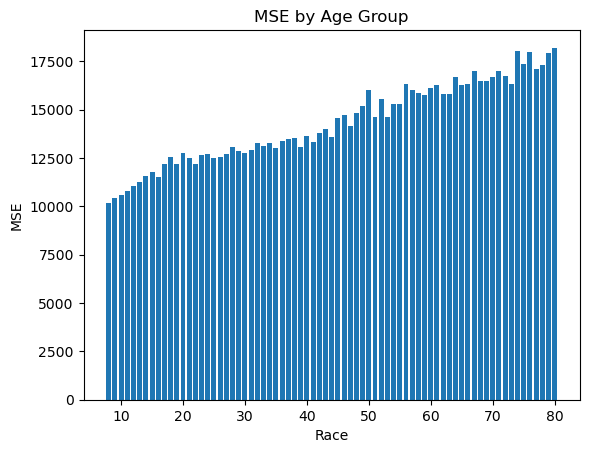

In [1059]:
group_mses=  {
    43.0: 13977.63,
    66.0: 16338.02,
    44.0: 13592.10,
    34.0: 13284.27,
    68.0: 16496.18,
    27.0: 12702.33,
    59.0: 15757.40,
    31.0: 12890.31,
    33.0: 13134.27,
    74.0: 18021.57,
    39.0: 13086.15,
    51.0: 14597.37,
    56.0: 16314.77,
    67.0: 17010.49,
    47.0: 14129.35,
    26.0: 12573.42,
    18.0: 12541.33,
    12.0: 11037.89,
    73.0: 16314.95,
    80.0: 18202.54,
    16.0: 11541.78,
    61.0: 16282.91,
    53.0: 14622.97,
    15.0: 11765.59,
    19.0: 12190.84,
    14.0: 11546.01,
    11.0: 10792.66,
    54.0: 15308.87,
    17.0: 12197.84,
    50.0: 16001.14,
    63.0: 15833.45,
    41.0: 13312.89,
    77.0: 17099.43,
    70.0: 16664.59,
    24.0: 12681.80,
    38.0: 13529.15,
    71.0: 16993.05,
    69.0: 16472.30,
    10.0: 10605.48,
    55.0: 15266.61,
    22.0: 12208.54,
    57.0: 16030.85,
    72.0: 16754.40,
    60.0: 16121.09,
    75.0: 17337.29,
    9.0: 10440.52,
    30.0: 12762.10,
    29.0: 12846.87,
    58.0: 15862.30,
    79.0: 17922.90,
    62.0: 15796.03,
    32.0: 13277.75,
    78.0: 17290.95,
    28.0: 13080.49,
    64.0: 16690.84,
    65.0: 16282.72,
    20.0: 12765.60,
    42.0: 13783.88,
    36.0: 13355.48,
    40.0: 13641.22,
    13.0: 11275.34,
    46.0: 14744.06,
    52.0: 15567.26,
    76.0: 17985.49,
    37.0: 13495.32,
    25.0: 12515.84,
    8.0: 10163.70,
    48.0: 14838.01,
    45.0: 14585.87,
    35.0: 12997.14,
    49.0: 15170.34,
    23.0: 12651.85,
    21.0: 12508.64,
}

plt.bar(group_mses.keys(), group_mses.values())
plt.xlabel('Race')
plt.ylabel('MSE')
plt.title('MSE by Age Group')
plt.show()

In [1061]:
group_mse_fairness(data, 'race')

race = 6.0: MSE = 14203.91
race = 3.0: MSE = 14580.89
race = 2.0: MSE = 13727.73
race = 1.0: MSE = 13209.90
race = 4.0: MSE = 15136.36
race = 7.0: MSE = 14267.11


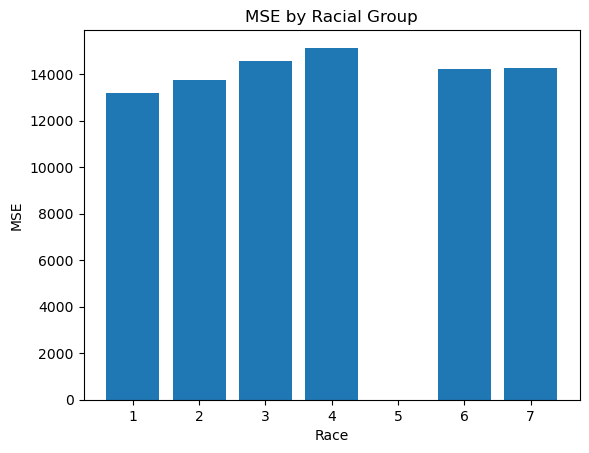

In [1064]:
group_mses = {
    6.0: 14203.91,
    3.0: 14580.89,
    2.0: 13727.73,
    1.0: 13209.90,
    4.0: 15136.36,
    7.0: 14267.11,
}

plt.bar(group_mses.keys(), group_mses.values())
plt.xlabel('Race')
plt.ylabel('MSE')
plt.title('MSE by Racial Group')
plt.show()

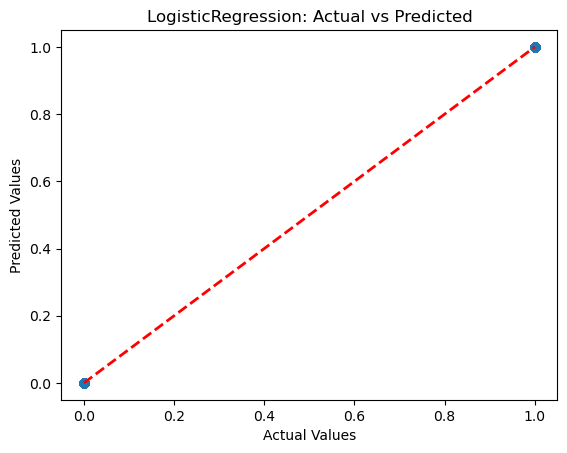

In [1066]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("LogisticRegression: Actual vs Predicted")
plt.show()

In [1068]:
print(data.columns)

Index(['id', 'age', 'race', 'gender', 'income_poverty_ratio', 'has_insurance',
       'private_insurance', 'time_without_insurance', 'systolic_1',
       'diastolic', 'systolic_2', 'diastolic_2', 'systolic_3', 'diastolic_3',
       'pulse_1', 'pulse_2', 'pulse_3', 'phlebo_wt', 'vitd_total',
       'vitd_total_comment', 'vitd2', 'vitd2_comment', 'vitd3',
       'vitd3_comment', 'epi-vitd3', 'epi-vitd3_comment', 'avg_systolic',
       'systolic_class', 'predicted', 'predicted_fair'],
      dtype='object')


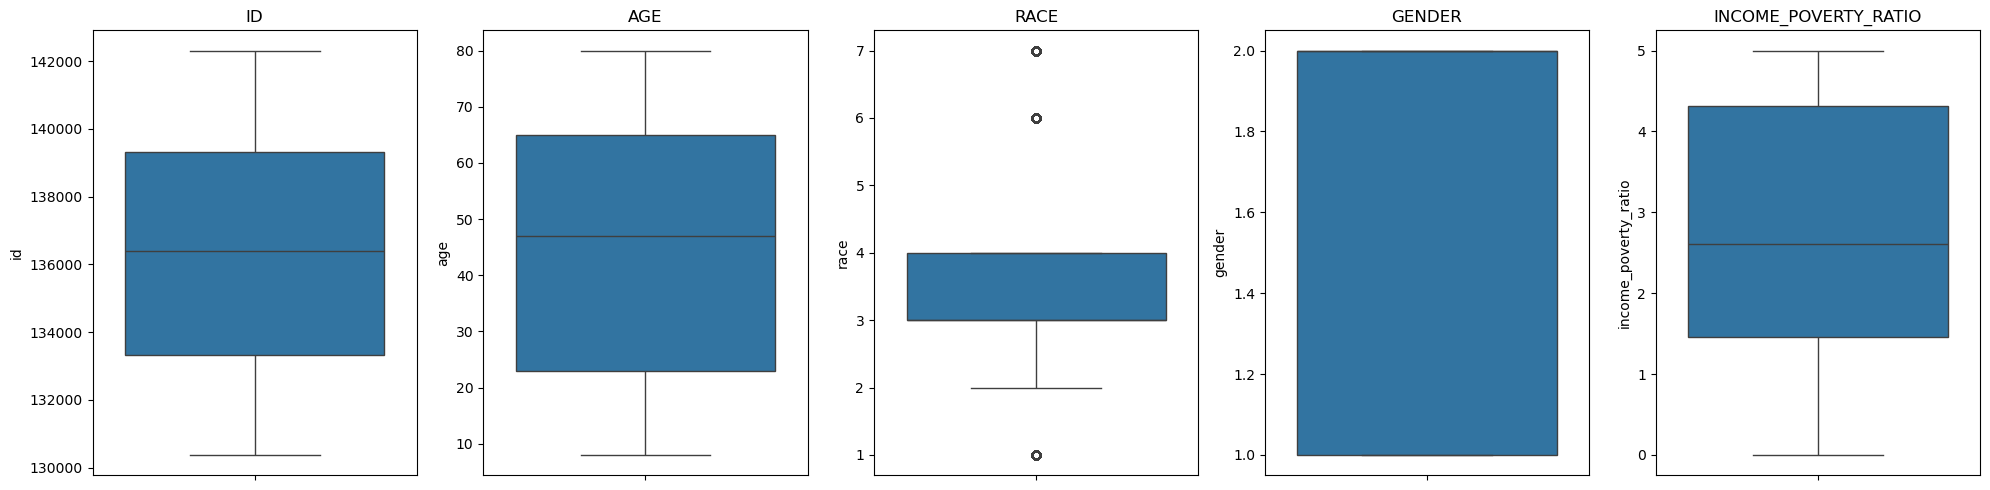

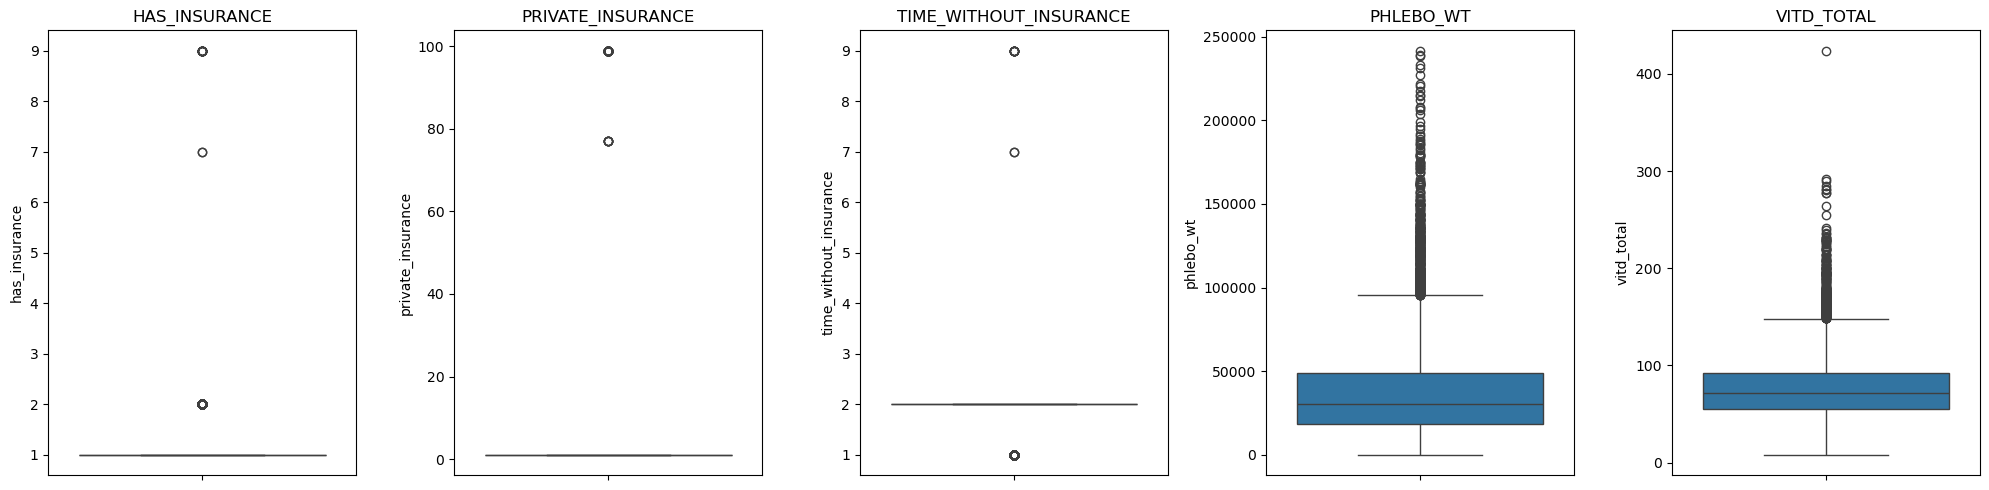

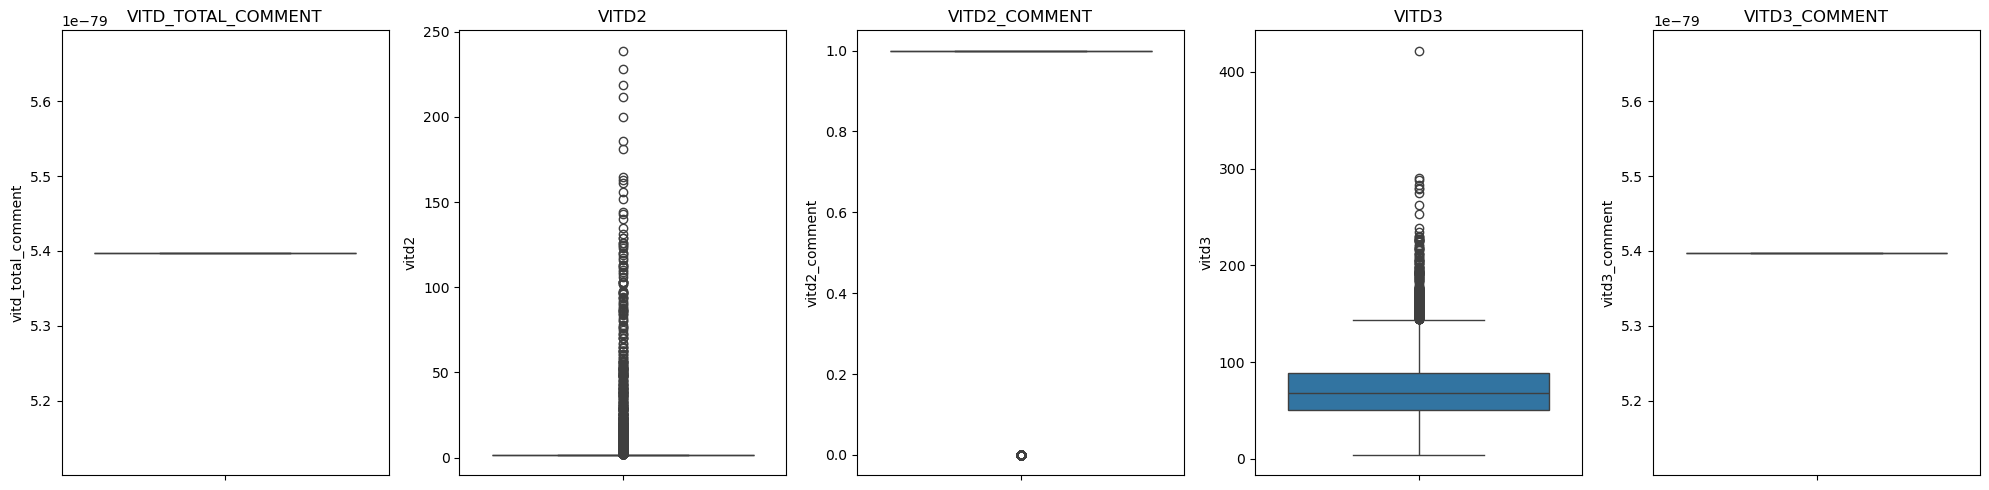

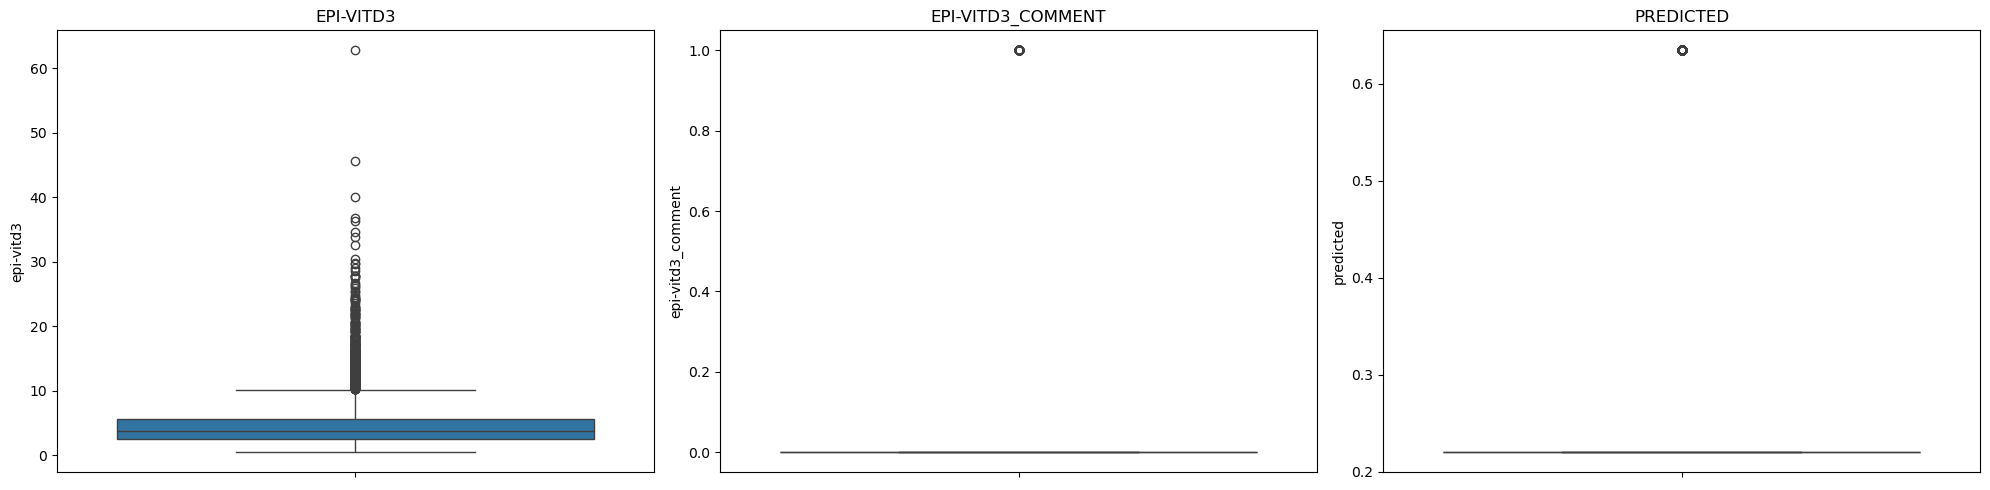

In [1070]:
# Step 2: Select only numeric columns
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 3: Plot in batches to avoid overcrowding
batch_size = 5
num_batches = len(numeric_features) // batch_size + (len(numeric_features) % batch_size != 0)

for batch in range(num_batches):
    start = batch * batch_size
    end = start + batch_size
    features_batch = numeric_features[start:end]

    plt.figure(figsize=(20, 5))
    for i, feature in enumerate(features_batch):
        plt.subplot(1, len(features_batch), i + 1)
        sns.boxplot(y=x[feature])
        plt.title(feature.upper())
        plt.tight_layout()
    plt.show()

In [1072]:
X_train = x  # your features
y_train = y  # your target (e.g., avg_systolic)
sensitive_features = data['race']

In [1074]:
# Base estimator
estimator = LinearRegression()

# Fairness mitigation using Demographic Parity
mitigator = ExponentiatedGradient(
    estimator,
    constraints=DemographicParity()
)

mitigator.fit(X_train, y_train, sensitive_features=sensitive_features)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x0000028C343DF200>,
                      estimator=LinearRegression(), nu=2.0466678648869563e-17)

In [1076]:
y_pred_fair = mitigator.predict(X_train)
data['predicted_fair'] = y_pred_fair

In [1078]:
def group_mse_fairness(data, sensitive_col, y_true_col, y_pred_col):
    groups = data[sensitive_col].unique()
    for group in groups:
        subset = data[data[sensitive_col] == group]
        mse = mean_squared_error(subset[y_true_col], subset[y_pred_col])
        print(f"{sensitive_col} = {group}: MSE = {mse:.2f}")

In [1080]:
group_mse_fairness(data, 'race', 'avg_systolic', 'predicted_fair')

race = 6.0: MSE = 14187.91
race = 3.0: MSE = 14565.01
race = 2.0: MSE = 13709.03
race = 1.0: MSE = 13186.35
race = 4.0: MSE = 15121.97
race = 7.0: MSE = 14254.32


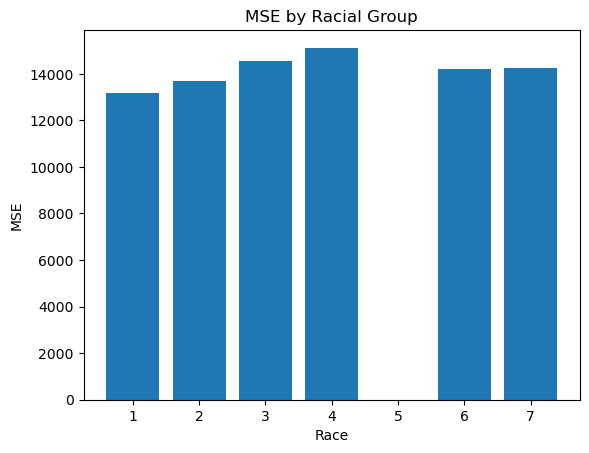

In [1082]:
group_mses = {
    6.0: 14185.57,
    3.0: 14566.32,
    2.0: 13706.16,
    1.0: 13187.92,
    4.0: 15120.05,
    7.0: 14253.52
}

plt.bar(group_mses.keys(), group_mses.values())
plt.xlabel('Race')
plt.ylabel('MSE')
plt.title('MSE by Racial Group')
plt.show()

In [1084]:
# Define your metrics
metrics = {
    "MSE": mean_squared_error,
    "MAE": mean_absolute_error,
    "R2": r2_score,
    "Mean Prediction": lambda y_true, y_pred: np.mean(y_pred),
    "Mean True": lambda y_true, y_pred: np.mean(y_true)
}

# Create MetricFrame
metric_frame = MetricFrame(
    metrics=metrics,
    y_true=data['avg_systolic'],
    y_pred=data['predicted'],
    sensitive_features=data['race']
)

# Show metrics by race
print(metric_frame.by_group)

# Optional: overall average
print("\nOverall Metrics:")
print(metric_frame.overall)

               MSE         MAE         R2  Mean Prediction   Mean True
race                                                                  
1.0   13209.903613  113.921333 -55.161545         0.283415  114.204748
2.0   13727.728818  115.940919 -46.428294         0.288200  116.229119
3.0   14580.890414  119.525493 -47.735319         0.316377  119.841870
4.0   15136.359935  121.397883 -36.396400         0.335118  121.733002
6.0   14203.914797  117.793224 -41.627977         0.298756  118.091979
7.0   14267.109305  118.018436 -40.519429         0.309372  118.327808

Overall Metrics:
MSE                14395.119113
MAE                  118.677258
R2                   -44.624652
Mean Prediction        0.311290
Mean True            118.988548
dtype: float64


In [1086]:
sensitive_feature = data['race']  # sensitive column we analyzing

In [1088]:
mf = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate,
    },
    y_true=y,
    y_pred=(y_pred_fair > 0.5).astype(int),
    sensitive_features=sensitive_feature
)

print(mf.by_group)
print("\nOverall Metrics:\n", mf.overall)

      accuracy  selection_rate  true_positive_rate
race                                              
1.0   0.666172        0.391691            0.689320
2.0   0.685057        0.371264            0.671329
3.0   0.695724        0.386278            0.676441
4.0   0.689552        0.399005            0.659498
6.0   0.682119        0.370861            0.639535
7.0   0.703499        0.364641            0.658120

Overall Metrics:
 accuracy              0.690937
selection_rate        0.384310
true_positive_rate    0.670938
dtype: float64


In [1090]:
x_train, x_test, y_train, y_test, sf_train, sf_test = train_test_split(
    x, y, sensitive_feature, test_size=0.3, random_state=42
)

In [1092]:
sensitive_features_train = sf_train
sensitive_features_test = sf_test

In [1094]:
x_train_nosensitive = x_train.drop(columns=['race'])
x_test_nosensitive = x_test.drop(columns=['race'])

In [1096]:
# Initialize the model and fairness constraint
base_model = LogisticRegression(solver='liblinear')
constraint = DemographicParity()  # or EqualizedOdds()

# Fairlearn's fairness-aware model
expgrad = ExponentiatedGradient(
    estimator=base_model,
    constraints=constraint
)

# Train the model
expgrad.fit(x_train_nosensitive, y_train, sensitive_features=sensitive_features_train)


ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x0000028C33521160>,
                      estimator=LogisticRegression(solver='liblinear'),
                      nu=0.002767242720953524)

In [1098]:
y_pred_fair = expgrad.predict(x_test_nosensitive)

In [1100]:
mf = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate,
    },
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=sensitive_features_test
)

In [1102]:
print(mf.by_group)
print("\nOverall Metrics:\n", mf.overall)

      accuracy  selection_rate  true_positive_rate
race                                              
1.0   0.870466        0.010363            0.074074
2.0   0.822134        0.011858            0.062500
3.0   0.752553        0.034564            0.064309
4.0   0.715686        0.022876            0.034884
6.0   0.815603        0.014184            0.038462
7.0   0.765714        0.005714            0.000000

Overall Metrics:
 accuracy              0.769757
selection_rate        0.025203
true_positive_rate    0.053903
dtype: float64


<Axes: xlabel='race'>

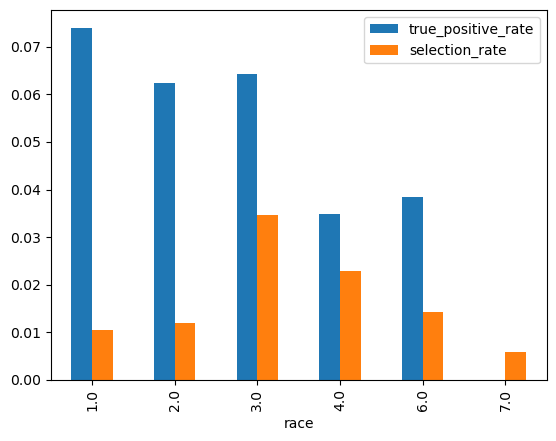

In [1104]:
mf.by_group[['true_positive_rate', 'selection_rate']].plot.bar()

In [1106]:
protected_attribute = 'race'
label_name = 'systolic_class'

In [1108]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

In [1110]:
# Convert to AIF360 dataset
train_bld = BinaryLabelDataset(df=pd.DataFrame(x_train, columns=x.columns).assign(**{label_name: y_train.values}),
                               label_names=[label_name],
                               protected_attribute_names=[protected_attribute])

test_bld = BinaryLabelDataset(df=pd.DataFrame(x_test, columns=x.columns).assign(**{label_name: y_test.values}),
                              label_names=[label_name],
                              protected_attribute_names=[protected_attribute])

In [ ]:
#Training Adversarial Debiasing 

In [1112]:
# Disable eager execution (if necessary)
tf.compat.v1.disable_eager_execution()

In [1114]:
# Reset TensorFlow session before fitting
tf.compat.v1.reset_default_graph()

In [1116]:
# Create a TensorFlow session
sess = tf.compat.v1.Session()

In [1118]:
# Define your AdversarialDebiasing model

ad = AdversarialDebiasing(
    privileged_groups=[{protected_attribute: 1.0}], 
    unprivileged_groups=[{protected_attribute: 2.0}], 
    scope_name='adversarial_debiasing',
    debias=True,
    batch_size=128,
    adversary_loss_weight=0.5,
    sess = sess
)

In [1120]:
# Train the model
ad.fit(train_bld)

epoch 0; iter: 0; batch classifier loss: 4114.379883; batch adversarial loss: 0.693147
epoch 1; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 4; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 5; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 6; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 7; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 8; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 9; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 10; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 11; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 12; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 13; iter: 0; bat

In [1122]:
preds = ad.predict(test_bld)

In [1124]:
# Evaluate the model
metric = ClassificationMetric(test_bld, preds,
                              unprivileged_groups=[{protected_attribute: 2.0}],
                              privileged_groups=[{protected_attribute: 1.0}])

In [1126]:
# Print performance and fairness metrics
print("Accuracy:", metric.accuracy())
print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Equal Opportunity Difference:", metric.equal_opportunity_difference())

Accuracy: 0.7701836821870995
Statistical Parity Difference: 0.0
Equal Opportunity Difference: 0.0


In [1128]:
y_true = test_bld.labels.ravel()

In [1130]:
# Threshold the predicted scores to get binary labels
y_pred_binary = (y_pred >= 0.5).astype(int)

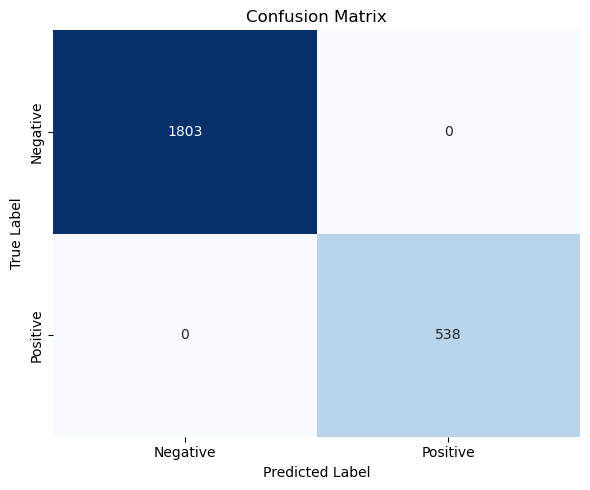

In [1132]:
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

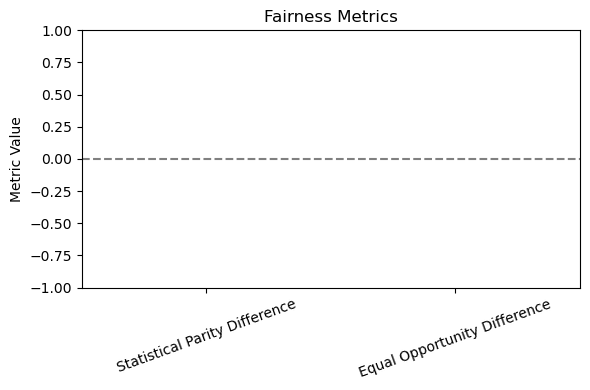

In [1134]:
# === 2. Fairness Metrics Bar Plot ===
spd = 0.0  # Replace with your computed value
eod = 0.0  # Replace with your computed value

plt.figure(figsize=(6, 4))
metrics = ['Statistical Parity Difference', 'Equal Opportunity Difference']
values = [spd, eod]
sns.barplot(x=metrics, y=values, color=sns.color_palette('viridis', n_colors=len(metrics))[0])
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Fairness Metrics')
plt.ylabel('Metric Value')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [1027]:
!jupyter nbconvert --to html BiasMitgate.ipynb


[NbConvertApp] Converting notebook BiasMitgate.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 941978 bytes to BiasMitgate.html
